# File Setup

In [41]:
max_year = 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from netCDF4 import dataset
import scipy as sp
import xarray as xr
import datetime
import pysmile
import pysmile_license
import pickle
from sklearn.cluster import KMeans
import folium
import scipy as sp

In [2]:
with open('Processed_data_and_output/clusters.json','rb') as fp:
    clust_dict = pickle.load(fp)

In [3]:
# See if I can plot the clusters
df_nanumea_TOB = pd.read_csv('Processed_data_and_output/modified_dataset.csv')

In [4]:
df_nanumea_TOB['cluster'] = [clust_dict[x] for x in df_nanumea_TOB['position']]

In [5]:
token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
location = [-5.676533, 176.122640]


In [6]:
df_nanumea_TOB_one_year = df_nanumea_TOB[df_nanumea_TOB.year2==2009]

map_osm = folium.Map(location=location, zoom_start=15, tiles=tileurl, attr='Mapbox')
name = 'name'
c = 'black'

c_list = ['blue','white','green','orange','red','yellow','pink']
lgd_txt = '<span style="color: {col};">{txt}</span>'
feature_group = folium.FeatureGroup(name= lgd_txt.format( txt=name, col= c))

for c,(index,group) in zip(c_list,df_nanumea_TOB_one_year.groupby('cluster')):
    # plt.scatter(group.x,group.y)
    lgd_txt = '<span style="color: {col};">{txt}</span>'
    
    for index,row in group.iterrows():
        mk = folium.CircleMarker(location=[row.lat,row.lon],color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,radius=3)
        
        feature_group.add_child(mk)

    
map_osm.add_child(feature_group)


folium.LayerControl().add_to(map_osm) 

map_osm

In [7]:
# cluster = 1

# fig = plt.figure(figsize=(10,10*12/3))
# # ax1 = plt.subplot2grid((12,2),(i,ds))

# ax_dict = {}
# for window in np.arange(0,12,1):
#     for ds in [0,1]:
#         ax1 = plt.subplot2grid((12,2),(window-12*int(window/12),ds))
#         ax1.set_title(window)
#         ax_dict.update({
#             (window,ds):ax1
#         })

# i=0
# for window in np.arange(0,36,1): 
#     for ds in [0,1]:
#         # ax1 = plt.subplot2grid((12,2),(window-12*int(window/12),ds))
#         ax1 = ax_dict[(window-12*int(window/12),ds)]
#         cluster_dict = dirr_bounds_dict[window][ds][cluster]
#         df_test = cluster_dict['scatters']
#         df_mv_avg = cluster_dict['moving_avg']

#         ax1.scatter(df_test.dirr,df_test['corr'],alpha=0.05,c='k')
#         ax1.plot(df_mv_avg.index,df_mv_avg['corr'])
        
#         if window<12:
#             if (max_window_2_dict[cluster]==window)|(max_window_1_dict[cluster]==window):
#                 ax1.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c='r')
#             else:
#                 ax1.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c='k')
#         ax1.plot([0,360],[0,0],c='0.5',zorder=-1100)

#         ax1.set_ylim([-1,1])
#         ax1.set_ylabel('Correlation')
#         ax1.set_xlabel('Direction')
    
#     i+=1

# # plt.savefig('Processed_data_and_output/figures/integrated_freq_corrs_opts_identified.png')
# plt.show()

In [8]:
def find_coordinate_index(data_array, coordinate_name, value):
    """
    Find the index of a coordinate in an xarray equal to a particular value.
    
    Parameters:
        data_array (xarray.DataArray): The xarray data array.
        coordinate_name (str): The name of the coordinate to search.
        value: The value to search for in the coordinate.
    
    Returns:
        tuple or None: The index of the coordinate if found, or None if not found.
    """
    coordinate = data_array[coordinate_name]
    index = coordinate.to_index().get_loc(value, method='nearest')
    if isinstance(index, int):
        return (index,)
    elif isinstance(index, slice):
        return index.indices(len(coordinate))
    else:
        return None

# Load Dataset

In [9]:
# Load correlations matrix
xr_corr = xr.load_dataarray('Processed_data_and_output/correlations.nc')

# Load dataframe with shoreline change according to TOB and additional variables created
df_nanumea_TOB = pd.read_csv('Processed_data_and_output/modified_dataset.csv')

# Load raw spectral data
nanumea_spectra_dict = sp.io.loadmat('Preprocessed_datasets/spectra/Nanumea_spec.mat')

days_since_jan_1979 = (nanumea_spectra_dict['tm']-np.min(nanumea_spectra_dict['tm']))[0,:]

dates_list = []
for timedelta in days_since_jan_1979:
    dates_list.append(datetime.datetime(1979,1,1)+datetime.timedelta(days=int(timedelta)))
    
dirs_list = [x[0] for x in nanumea_spectra_dict['dirs']]
dirs_list = dirs_list-np.min(dirs_list)
frqs = [x[0] for x in nanumea_spectra_dict['frqs']]

xr_E_MM = xr.DataArray(data=nanumea_spectra_dict['E_MM'],coords=[dates_list,frqs,dirs_list],
                    dims=['time','freq','dirr'])

xr_E_95 = xr.DataArray(data=nanumea_spectra_dict['E_95'],coords=[dates_list,frqs,dirs_list],
                    dims=['time','freq','dirr'])

# nanumea_dates = list(pd.read_csv('Preprocessed_datasets/Nanumea_dates.tsv',sep='\t'))
# nanumea_dates = \
#     [pd.to_datetime(x) for x in nanumea_dates]

# nanumea_dict = {date.year:date for date in nanumea_dates}

# Reload dictionary from file
with open('dates_dict.pkl', 'rb') as f:
    nanumea_dict = pickle.load(f)

with open('Processed_data_and_output/clusters.json','rb') as fp:
    clust_dict = pickle.load(fp)
    
list_of_clusts = np.unique(list(clust_dict.values()))

# Plot of the correlations with freq integrated over different time horizons

In [10]:
xr_corr_int = xr_corr.integrate('freq')

In [11]:
df_clusts = pd.DataFrame.from_dict(clust_dict,orient='index')
df_temp = df_clusts.diff()
df_temp = df_temp[df_temp[0]==1]
cluster_bounds = list(df_temp.index)
cluster_bounds = list(df_clusts.reset_index()[df_clusts.reset_index()['index'].isin(cluster_bounds)].index)

In [12]:
xr_corr

<xarray.DataArray (position: 200, freq: 37, dirr: 36, window_size: 12)>
array([[[[-3.51861355e-01, -8.99122790e-02, -3.89701005e-02, ...,
          -7.12574084e-02,  9.86287755e-02, -1.30607968e-01],
         [-3.46857244e-01, -1.05859336e-01, -1.24426090e-01, ...,
          -6.47634094e-02,  1.68657793e-01, -6.41276541e-02],
         [-3.24088860e-01, -1.21252478e-01, -2.07062676e-01, ...,
          -5.31023148e-02,  2.23355228e-01,  1.94576093e-02],
         ...,
         [-3.62060685e-01, -6.45301260e-02, -1.60664739e-02, ...,
          -1.43428139e-01,  2.48625584e-02, -1.52049233e-01],
         [-3.61879203e-01, -5.51908731e-02,  1.87582146e-02, ...,
          -1.15604915e-01,  2.48509968e-02, -1.45124452e-01],
         [-3.55554824e-01, -5.53161022e-02,  2.46043796e-02, ...,
          -1.00930888e-01,  3.56921205e-02, -1.40467654e-01]],

        [[-3.51861355e-01, -8.99122790e-02, -3.89701005e-02, ...,
          -7.12574084e-02,  9.86287755e-02, -1.30607968e-01],
         [-3.46857244e-01, -1.05859336e-01, -1.24426090e-01, ...,
          -6.47634094e-02,  1.68657793e-01, -6.41276541e-02],
         [-3.24088860e-01, -1.21252478e-01, -2.07062676e-01, ...,
          -5.31023148e-02,  2.23355228e-01,  1.94576093e-02],
...
         [-8.79569721e-02, -1.03120400e-01, -1.14628613e-01, ...,
          -1.41723134e-01,  2.27695057e-01, -2.85672082e-02],
         [-8.39671708e-02, -1.22740741e-01, -1.26146664e-01, ...,
          -1.29796156e-01,  1.87646283e-01,  1.28617872e-03],
         [-7.54557357e-02, -1.36851970e-01, -1.44001516e-01, ...,
          -1.19120722e-01,  1.60910840e-01,  1.89137954e-02]],

        [[-6.79049931e-02, -1.45931531e-01, -2.06343404e-01, ...,
          -9.65062917e-02,  1.24931100e-01,  1.11830028e-02],
         [-5.41165987e-02, -1.64273258e-01, -2.59731509e-01, ...,
          -9.44335890e-02,  1.37159198e-01, -3.46764859e-02],
         [-3.76632174e-02, -1.82119518e-01, -2.98331159e-01, ...,
          -8.37724599e-02,  1.56659548e-01, -9.60077742e-02],
         ...,
         [-8.79334821e-02, -1.03111171e-01, -1.14621191e-01, ...,
          -1.41719645e-01,  2.27705315e-01, -2.85629579e-02],
         [-8.39493183e-02, -1.22731374e-01, -1.26141765e-01, ...,
          -1.29793096e-01,  1.87657137e-01,  1.29031993e-03],
         [-7.54388042e-02, -1.36841142e-01, -1.43997864e-01, ...,
          -1.19118673e-01,  1.60919566e-01,  1.89176320e-02]]]])
Coordinates:
  * window_size  (window_size) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * position     (position) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * freq         (freq) float64 0.033 0.0363 0.0399 0.0439 ... 0.8274 0.9096 1.0
  * dirr         (dirr) float64 0.0 10.0 20.0 30.0 ... 320.0 330.0 340.0 350.0

In [13]:
xr_corr_int

<xarray.DataArray (position: 200, dirr: 36, window_size: 12)>
array([[[-3.40249931e-01, -8.69451738e-02, -3.76840871e-02, ...,
         -6.89059139e-02,  9.53740260e-02, -1.26297905e-01],
        [-3.35410955e-01, -1.02365978e-01, -1.20320029e-01, ...,
         -6.26262169e-02,  1.63092086e-01, -6.20114415e-02],
        [-3.13393927e-01, -1.17251146e-01, -2.00229608e-01, ...,
         -5.13499384e-02,  2.15984505e-01,  1.88155082e-02],
        ...,
        [-3.50112682e-01, -6.24006318e-02, -1.55362802e-02, ...,
         -1.38695011e-01,  2.40420939e-02, -1.47031608e-01],
        [-3.49937189e-01, -5.33695743e-02,  1.81391936e-02, ...,
         -1.11789952e-01,  2.40309139e-02, -1.40335345e-01],
        [-3.43821515e-01, -5.34906708e-02,  2.37924351e-02, ...,
         -9.76001688e-02,  3.45142805e-02, -1.35832221e-01]],

       [[-2.35778487e-01, -2.02686420e-01, -2.18515463e-01, ...,
          6.54136591e-02,  1.51393982e-01, -4.01643610e-02],
        [-2.56279648e-01, -2.25829684e-01, -2.77743417e-01, ...,
          6.06213090e-02,  2.11853673e-01,  2.28061275e-02],
        [-2.77554335e-01, -2.34165855e-01, -3.33301795e-01, ...,
          4.81557369e-02,  2.55112290e-01,  9.83040565e-02],
...
        [-3.68057040e-01, -1.15557548e-01, -1.40914028e-01, ...,
         -8.06189505e-02, -3.58470805e-02,  9.66945905e-02],
        [-3.52872627e-01, -1.25549254e-01, -1.32949666e-01, ...,
         -5.60686051e-02, -3.82688415e-02,  8.22875800e-02],
        [-3.41731845e-01, -1.32420134e-01, -1.39225548e-01, ...,
         -4.23107456e-02, -2.92943977e-02,  6.66272497e-02]],

       [[-6.96842322e-02, -1.44017027e-01, -2.01985181e-01, ...,
         -9.50455694e-02,  1.08885724e-01,  5.20019010e-03],
        [-5.82909589e-02, -1.62532367e-01, -2.53558416e-01, ...,
         -9.37372919e-02,  1.20728067e-01, -3.83127727e-02],
        [-4.44865488e-02, -1.80426712e-01, -2.89234378e-01, ...,
         -8.37912574e-02,  1.39885353e-01, -9.70388278e-02],
        ...,
        [-8.80672232e-02, -1.00777171e-01, -1.11163675e-01, ...,
         -1.37340449e-01,  2.11794180e-01, -3.20769118e-02],
        [-8.37263603e-02, -1.19921306e-01, -1.22450797e-01, ...,
         -1.25791244e-01,  1.70760598e-01, -4.47214292e-03],
        [-7.54609553e-02, -1.33907292e-01, -1.40078272e-01, ...,
         -1.15593806e-01,  1.43387595e-01,  1.17921544e-02]]])
Coordinates:
  * window_size  (window_size) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * position     (position) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * dirr         (dirr) float64 0.0 10.0 20.0 30.0 ... 320.0 330.0 340.0 350.0

In [16]:
position

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


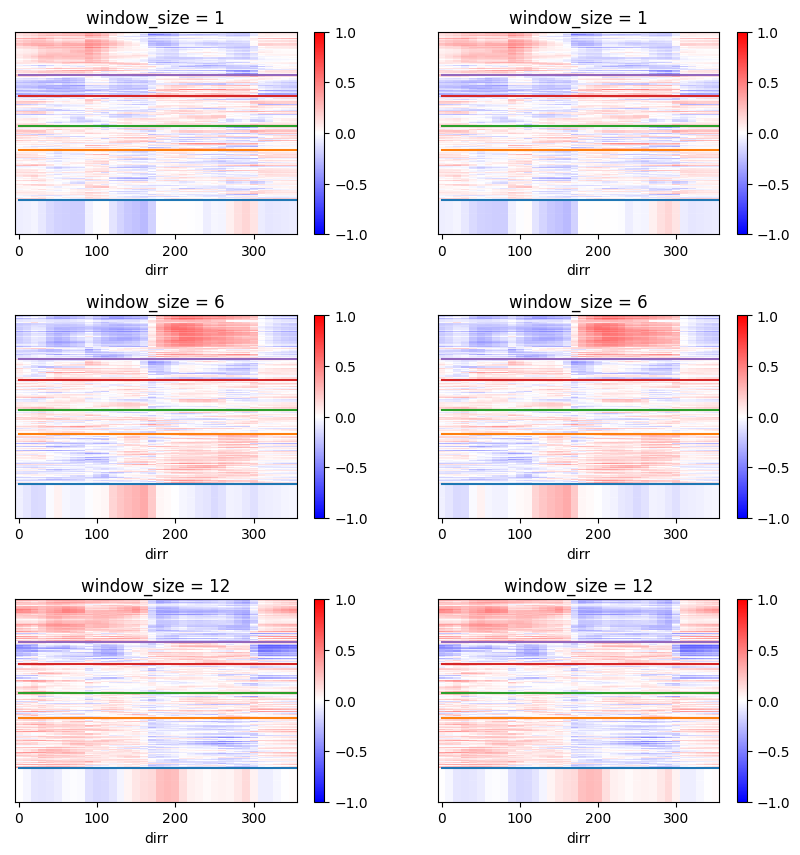

In [21]:
xr_corr_int = xr_corr.integrate('freq')
position = list(np.array(xr_corr.position))
xr_corr_int = xr_corr_int[list(clust_dict.keys()),:,:]
xr_corr_int['position'] = np.arange(0,len(xr_corr_int.position),1)#position

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.4)

i = 0
for window in [0,5,11]:#np.arange(0,12,1):
    for ds in [0,1]:
        ax1 = plt.subplot2grid((3,2),(i,ds))
        xr.plot.pcolormesh(xr_corr_int[:,:,window],cmap='bwr',vmin=-1,vmax=1,add_colorbar=True,ax=ax1)

        df_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]
        df_year = df_year.sort_values('position')
        
        for cluster_bound in cluster_bounds:
            ax1.plot([0,360],[cluster_bound,cluster_bound])
        ax1.set_ylabel('')
        ax1.set_yticks([])
    i+=1
            
plt.savefig('Processed_data_and_output/figures/integrated_freq_corrs_reordered.png')

0
5
11


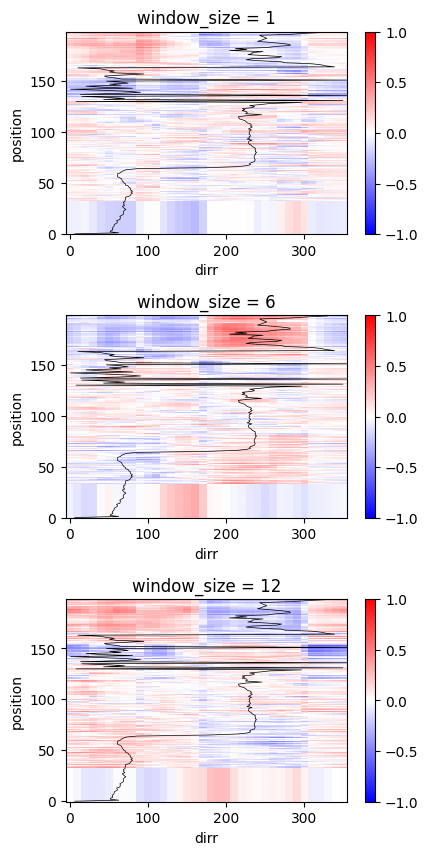

In [22]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.4)

i=0
for window in [0,5,11]:#np.arange(0,12,1):
    print(window)
    ax1 = plt.subplot2grid((3,2),(i,ds))
    xr.plot.pcolormesh(xr_corr_int[:,:,window],cmap='bwr',vmin=-1,vmax=1,add_colorbar=True,ax=ax1)

    df_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]
    df_year = df_year.sort_values('position')
    ax1.plot(df_year.shoreline_direction,df_year.position,c='k',lw=0.5)
    # ax1.set_xlabel('')
    i+=1

plt.savefig('Processed_data_and_output/figures/integrated_freq_corrs.png')

In [23]:
cluster_bounds_for_iter = [0]+cluster_bounds+[np.array(xr_corr_int.position).max()]

In [24]:
corr_threshold = 0.05

dirr_bounds_dict = {}
for window in np.arange(0,12,1):
    dataset_dict = {}
    for ds in [0,1]:
        cluster_dict = {}
        i = 0
        for cluster_bound_lower,cluster_bound_upper in zip(cluster_bounds_for_iter[:-1],cluster_bounds_for_iter[1:]):
            
            xr_test = xr_corr_int[cluster_bound_lower:cluster_bound_upper,:,window]
            df_test = xr_test.to_dataframe('corr')
            df_test = df_test.reset_index()
            df_mv_avg = df_test.groupby('dirr').mean()   
                
            #An alternative way to do this
            xr_test_mean = xr_test.mean(dim='position')
            xr_test_neg = xr_test_mean.where(xr_test_mean<0,0)
            xr_test_pos = xr_test_mean.where(xr_test_mean>0,0)
                
            cluster_dict.update({
                i:{
                    'scatters':df_test,
                    'moving_avg':df_mv_avg,
                    'pos_weights':xr_test_pos,
                    'neg_weights':xr_test_neg
                }
            })
            i+=1
        dataset_dict.update({
            ds:cluster_dict
        })
    dirr_bounds_dict.update({
        window:dataset_dict
    })


In [25]:
avg_of_avg = {}
avg_clust_diffs = {}

for cluster in list_of_clusts:
    for window in np.arange(0,12,1): 
        df_mv_avg_1 = dirr_bounds_dict[window][0][cluster]['moving_avg']
        
        df_mv_avg_1 = df_mv_avg_1[['corr']]
        df_mv_avg_1.columns = [1]
        
        df_mv_avg_avg = pd.DataFrame(df_mv_avg_1).mean(axis=1)
        avg_of_avg.update({
            (cluster,window):df_mv_avg_avg
        })
        
        avg_clust_diffs.update({
            (cluster,window):np.abs(df_mv_avg_avg).sum()
        })
        
max_window_1_dict = {}
for cluster in list_of_clusts:
    df_clust_deviation = pd.DataFrame.from_dict(avg_clust_diffs,orient='index').copy()
    df_clust_deviation['cluster'] = [x[0] for x in df_clust_deviation.index]
    df_clust_deviation['window'] = [x[1] for x in df_clust_deviation.index]
    df_clust_deviation = df_clust_deviation[df_clust_deviation.cluster==cluster]
    max_window_1 = df_clust_deviation.loc[df_clust_deviation[0]==np.max(df_clust_deviation[0]),'window'].values[0]
    max_window_1_dict.update({
        cluster:max_window_1
    })

# find opposing signal
max_window_2_dict = {}
for cluster in list_of_clusts:
    max_window_1 = max_window_1_dict[cluster].copy()
    max_diff = {}
    for window in np.arange(0,12,1):
        df_diff = avg_of_avg[(cluster,window)]-avg_of_avg[(cluster,max_window_1)]
        max_diff.update({
            np.abs(df_diff).sum():window
        })
    max_window_2 = max_diff[np.max(list(max_diff.keys()))]
    
    max_window_2_dict.update({
        cluster:max_window_2
    })

In [26]:
min_first_dict = {}
max_first_dict = {}

for cluster in list_of_clusts:
    if int(avg_of_avg[(cluster,max_window_1_dict[cluster])].idxmin())<int(avg_of_avg[(cluster,max_window_1_dict[cluster])].idxmax()):
        min_first_dict.update({
            cluster:max_window_1_dict[cluster]
        })
        max_first_dict.update({
            cluster:max_window_2_dict[cluster]
        })
    else:
        min_first_dict.update({
            cluster:max_window_2_dict[cluster]
        })
        max_first_dict.update({
            cluster:max_window_1_dict[cluster]
        })

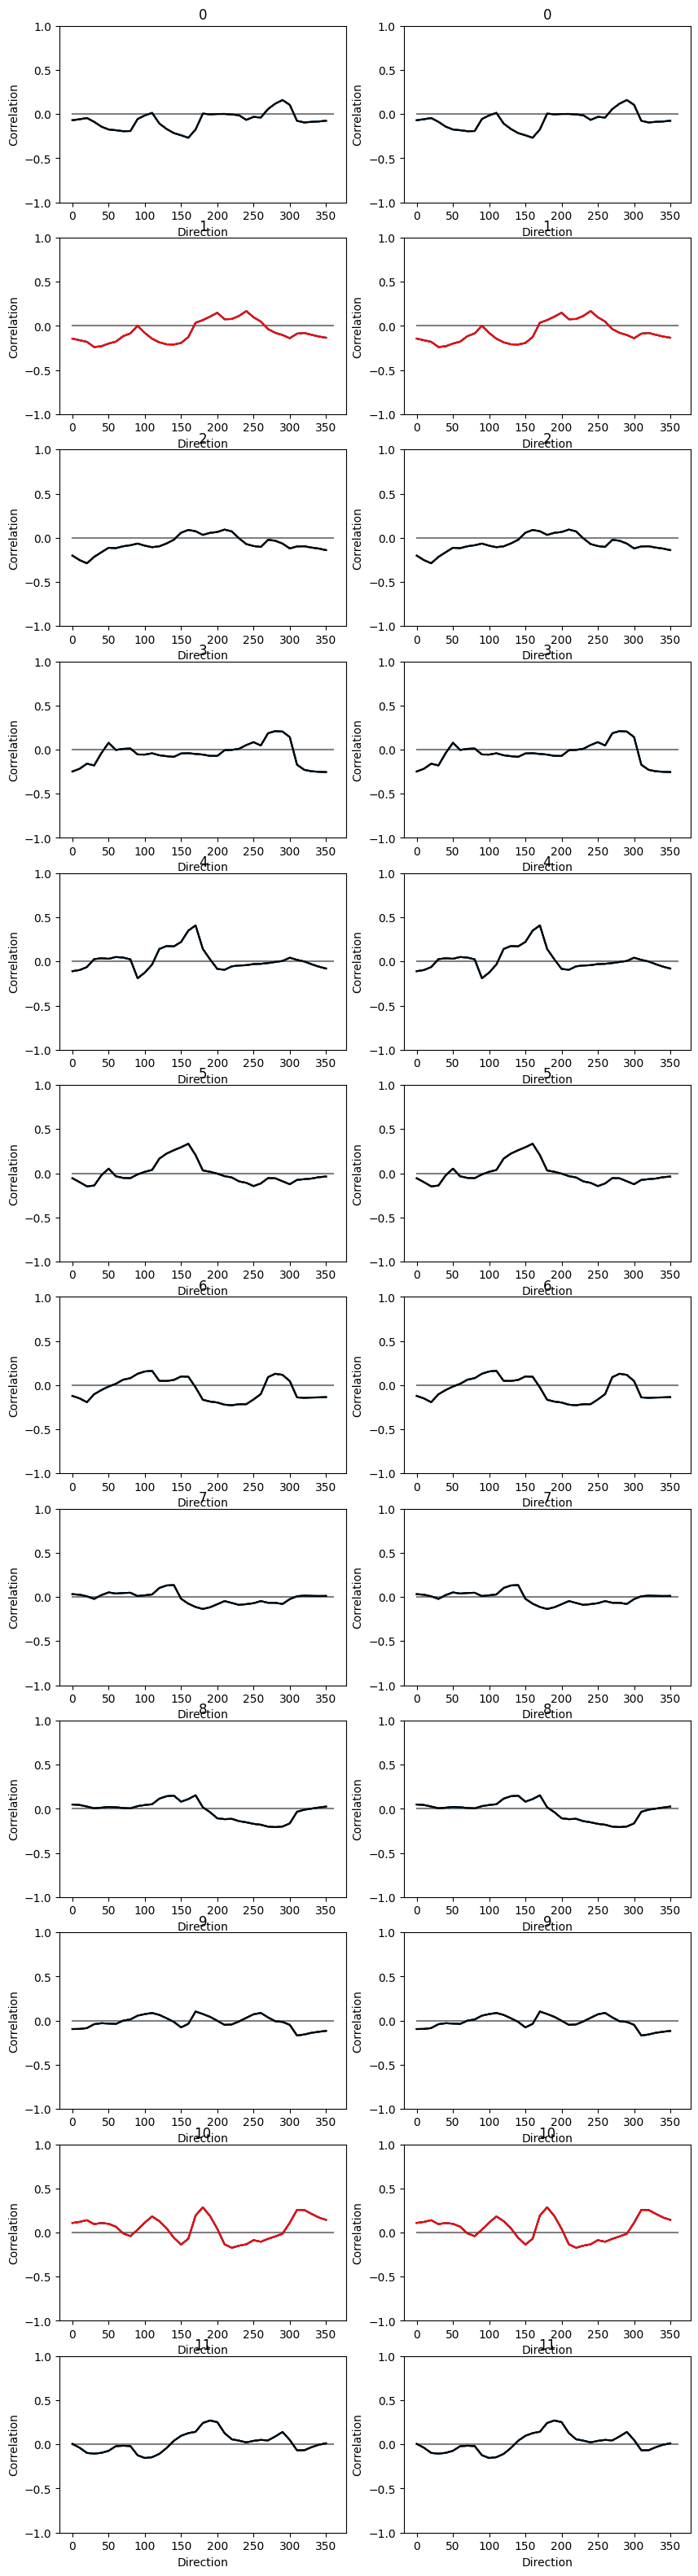

In [27]:
cluster = 0

fig = plt.figure(figsize=(10,10*12/3))
# ax1 = plt.subplot2grid((12,2),(i,ds))

ax_dict = {}
for window in np.arange(0,12,1):
    for ds in [0,1]:
        ax1 = plt.subplot2grid((12,2),(window-12*int(window/12),ds))
        ax1.set_title(window)
        ax_dict.update({
            (window,ds):ax1
        })

i=0
for window in np.arange(0,12,1): 
    for ds in [0,1]:
        # ax1 = plt.subplot2grid((12,2),(window-12*int(window/12),ds))
        ax1 = ax_dict[(window-12*int(window/12),ds)]
        cluster_dict = dirr_bounds_dict[window][ds][cluster]
        df_test = cluster_dict['scatters']
        df_mv_avg = cluster_dict['moving_avg']

        for pos,group in df_test.groupby('position'):
            ax1.plot(group.dirr,group['corr'],alpha=0.05,c='k')
            
        ax1.plot(df_mv_avg.index,df_mv_avg['corr'])
        
        if window<12:
            if (max_window_2_dict[cluster]==window)|(max_window_1_dict[cluster]==window):
                # ax1.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c='r')
                ax1.plot(avg_of_avg[(cluster,window)],c='r')
            else:
                # ax1.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c='k')
                ax1.plot(avg_of_avg[(cluster,window)],c='k')
        ax1.plot([0,360],[0,0],c='0.5',zorder=-1100)

        ax1.set_ylim([-1,1])
        ax1.set_ylabel('Correlation')
        ax1.set_xlabel('Direction')
    
    i+=1

plt.savefig('Processed_data_and_output/figures/integrated_freq_corrs_opts_identified.png')
plt.show()

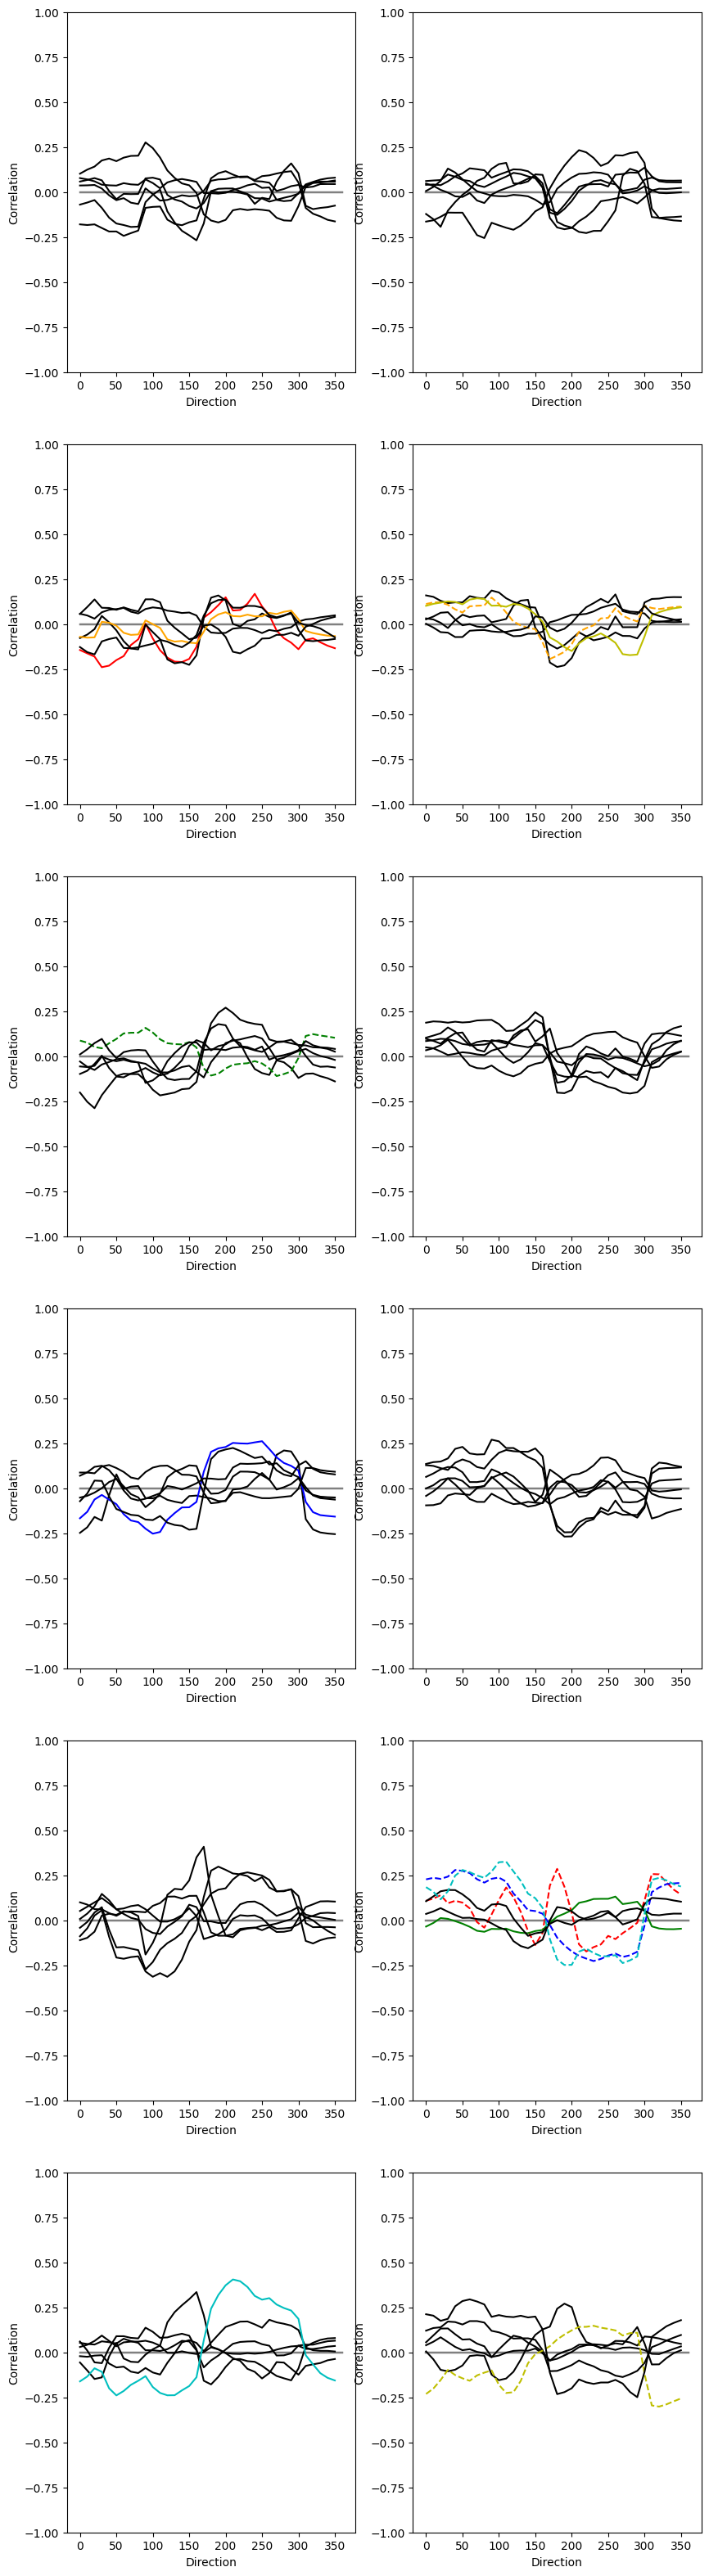

In [28]:
colour_dict = {
    0:'r',
    1:'b',
    2:'g',
    3:'orange',
    4:'y',
    5:'c'
}

fig = plt.figure(figsize=(10,10*12/3))

ax1 = plt.subplot2grid((6,2),(0,0))
ax2 = plt.subplot2grid((6,2),(1,0))
ax3 = plt.subplot2grid((6,2),(2,0))
ax4 = plt.subplot2grid((6,2),(3,0))
ax5 = plt.subplot2grid((6,2),(4,0))
ax6 = plt.subplot2grid((6,2),(5,0))
ax7 = plt.subplot2grid((6,2),(0,1))
ax8 = plt.subplot2grid((6,2),(1,1))
ax9 = plt.subplot2grid((6,2),(2,1))
ax10 = plt.subplot2grid((6,2),(3,1))
ax11 = plt.subplot2grid((6,2),(4,1))
ax12 = plt.subplot2grid((6,2),(5,1))

i=0
for cluster in list_of_clusts:
    for window,ax in zip(np.arange(0,12,1),[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]): 

        if (min_first_dict[cluster]==window):#
            # ax.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c=colour_dict[cluster])
            ax.plot(avg_of_avg[(cluster,window)],c=colour_dict[cluster])
        elif (max_first_dict[cluster]==window):
            # ax.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c=colour_dict[cluster],ls='--')
            ax.plot(avg_of_avg[(cluster,window)],c=colour_dict[cluster],ls='--')
        else:
            # ax.plot(avg_of_avg[(cluster,window)].index,avg_of_avg[(cluster,window)][0],c='k')
            ax.plot(avg_of_avg[(cluster,window)],c='k')

        ax.plot([0,360],[0,0],c='0.5',zorder=-1100)


        ax.set_ylim([-1,1])
        ax.set_ylabel('Correlation')
        ax.set_xlabel('Direction')


# plt.savefig('Processed_data_and_output/figures/integrated_freq_corrs_opts_identified.png')
plt.show()

# Visualise the clusters by the time lag

In [29]:
min_first_dict

{0: 1, 1: 3, 2: 10, 3: 1, 4: 7, 5: 5}

In [30]:
from matplotlib.colors import ListedColormap

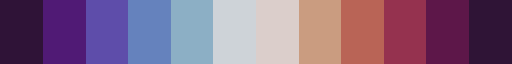

In [31]:
cmap = plt.cm.get_cmap('twilight_shifted')

new_cmap = ListedColormap(cmap(np.linspace(0,1,12)))
new_cmap

In [32]:
df_nanumea_TOB_one_year

,Unnamed: 0,position,x,x+n,y,y+n,lon,lat,m_shoreline,m_transect,...,month,month_split,TCSeason,spring,winter,autum,summer,season,MEI,cluster
199,397,132,401633.494159,401667.115428,9.373323e+06,9.373258e+06,176.111725,-5.668875,-1.925167,0.519435,...,3,3,True,False,False,True,False,autum,-1.030769,1
200,398,133,401667.115428,401700.492894,9.373258e+06,9.373193e+06,176.112027,-5.669461,-1.965560,0.508761,...,3,3,True,False,False,True,False,autum,-1.030769,1
201,399,134,401700.492894,401751.653325,9.373193e+06,9.373146e+06,176.112328,-5.670055,-0.911928,1.096578,...,3,3,True,False,False,True,False,autum,-1.030769,0
202,400,135,401751.653325,401825.462280,9.373146e+06,9.373146e+06,176.112789,-5.670477,-0.004093,244.329175,...,3,3,True,False,False,True,False,autum,-1.030769,1
203,401,136,401825.462280,401899.192763,9.373146e+06,9.373147e+06,176.113456,-5.670481,0.019719,-50.712082,...,3,3,True,False,False,True,False,autum,-1.030769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,591,127,401518.924736,401472.350819,9.373110e+06,9.373167e+06,176.110687,-5.670805,-1.230981,0.812360,...,3,3,True,False,False,True,False,autum,-1.030769,1
394,592,128,401472.350819,401449.340824,9.373167e+06,9.373237e+06,176.110267,-5.670286,-3.025922,0.330478,...,3,3,True,False,False,True,False,autum,-1.030769,5
395,593,129,401449.340824,401493.702637,9.373237e+06,9.373324e+06,176.110061,-5.669656,1.973489,-0.506717,...,3,3,True,False,False,True,False,autum,-1.030769,1
396,594,130,401493.702637,401566.454987,9.373324e+06,9.373314e+06,176.110462,-5.668864,-0.142249,7.029939,...,3,3,True,False,False,True,False,autum,-1.030769,1


# Create Features for BN

In [39]:
np.datetime64(nanumea_dict[year])

numpy.datetime64('2022-12-30T00:00:00.000000')

In [44]:
xr_E_MM_int = xr_E_MM.integrate('freq')

wave_node_values_per_year = {}
for year in np.unique(list(nanumea_dict.keys())):
    if year>max_year:
        continue
    wave_node_values = {}
    for cluster in list_of_clusts:
        for month in [max_window_1_dict[cluster],max_window_2_dict[cluster]]:
            current_time_index = find_coordinate_index(xr_E_MM_int,'time',np.array(xr_E_MM_int[xr_E_MM_int.time>np.datetime64(nanumea_dict[year])].time)[0])[0]-1
            # previous_time_index = current_time_index-month-1
            month+=1 # NEED TO HAVE THIS BECAUSE THE MONTH COUNT HERE STARTS AT ZERO NOT 1
            xr_E_MM_int_time_slice = xr_E_MM_int[(current_time_index-month):(current_time_index-(month-1)),:]
            xr_E_MM_int_time_slice = xr_E_MM_int_time_slice.mean('time')
            xr_E_MM_int_time_slice = xr_E_MM_int_time_slice.sortby('dirr')
                    
            df_directions = avg_of_avg[(cluster,max_window_1_dict[cluster])]
            min_directions = [int(round(x,0)) for x in list(df_directions[df_directions<0].index)]
            max_directions = [int(round(x,0)) for x in list(df_directions[df_directions>0].index)]
            
            mean_min = np.array(xr_E_MM_int_time_slice[[True if x in min_directions else False for x in list(np.array(xr_E_MM_int_time_slice.dirr))]]).mean()
            mean_max = np.array(xr_E_MM_int_time_slice[[True if x in max_directions else False for x in list(np.array(xr_E_MM_int_time_slice.dirr))]]).mean()
            
            wave_node_values.update({
                (month,cluster,'minn'):mean_min,
                (month,cluster,'maxx'):mean_max
            })

    # df_wave_node_values = pd.DataFrame.from_dict(wave_node_values,orient='index')
    wave_node_values_per_year.update({
        year:wave_node_values
    })
        
wave_node_values_per_clust = {}

df = pd.DataFrame.from_dict(wave_node_values_per_year)
for clust, group in df.reset_index().groupby('level_1'):
    wave_node_values_per_clust.update({
        clust:group.rename(columns={'level_0':'month','level_2':'MinOrMax'}).drop('level_1',axis=1).set_index(['month','MinOrMax']).T
    })

In [45]:
testing_features_dict = {}
for cluster in list_of_clusts:
    df = df_nanumea_TOB[df_nanumea_TOB[f'clust_{len(list_of_clusts)}']==cluster]
    df = df[['position','year2','intersect_distance']].set_index('year2')
    df_features = wave_node_values_per_clust[cluster]
    df = df.join(df_features)
    
    testing_features_dict.update({
        cluster:df
    })
    

/home/shannonb/miniconda3/envs/pac_model/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/shannonb/miniconda3/envs/pac_model/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/shannonb/miniconda3/envs/pac_model/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/shannonb/miniconda3/envs/pac_model/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarni

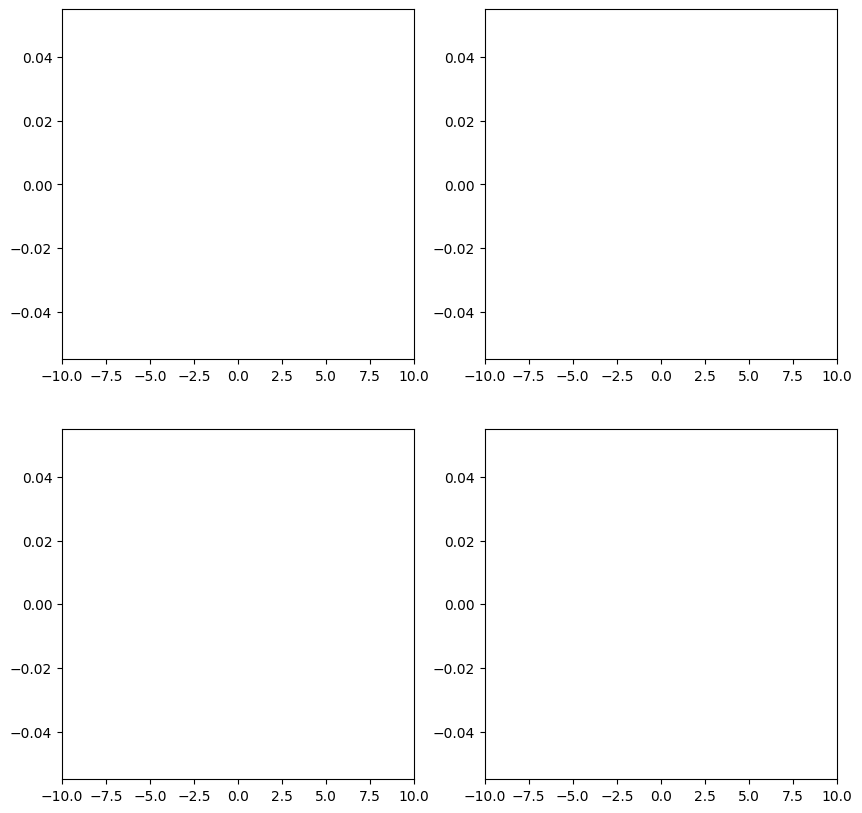

In [46]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0))
ax4 = plt.subplot2grid((2,2),(1,1))


cluster = 3
df = testing_features_dict[cluster]
independent_variables = list(df.columns)
independent_variables = [x for x in independent_variables if (x!='intersect_distance')&(x!='position')]

for position,group in df.groupby('position'):
    group = group.sort_values('intersect_distance')
    group['intersect_distance'] = group['intersect_distance']-group['intersect_distance'].mean()
    for col,ax in zip(independent_variables,[ax1,ax2,ax3,ax4]):
        ax.scatter(group.intersect_distance,group[col],alpha=0.1,c='r')
        # else:
        #     ax2.scatter(group.intersect_distance,group[col],alpha=0.1,c='r')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim([-10,10])

In [ ]:
df.groupby('position').mean()

In [ ]:
df.corr()

In [ ]:
asdf

# Load Tairua Data

In [ ]:
!pwd

In [ ]:
df_tairua_data = pd.read_csv('Tairua_data/DL_shoreline_prediction/data/inputs_target.csv')

In [ ]:
df_tairua_data = df_tairua_data.set_index('Datetime')

In [ ]:
df_tairua_data.index = [datetime.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])) for x in df_tairua_data.index]

In [ ]:
# for index,row in df_tairua_data.iterrows():
#     index-datetime.timedelta(month=
    

In [ ]:
df_tairua_data

# Setup BN

In [47]:
pd.options.mode.chained_assignment = None
summary_results_dict = {}
true_positive_results_dict = {}
true_negative_results_dict = {}
false_positive_results_dict = {}
false_negative_results_dict = {}

individual_results_list = []


for cluster_selected in wave_node_values_per_clust.keys():
    for test_year in np.unique(df_nanumea_TOB.year2):
        if test_year==2005:
            continue
        df_waves_one_cluster = wave_node_values_per_clust[cluster_selected].copy()
        df_waves_one_cluster.columns = [y+str(x) for (x,y) in list(df_waves_one_cluster)]
        # df_waves_one_cluster = df_waves_one_cluster[[x for x in df_waves_one_cluster if (x in ['maxx'+str(x) for x in pos_selected_nodes_dict[cluster_selected]])|(x in ['minn'+str(x) for x in neg_selected_nodes_dict[cluster_selected]])]]
        df_nanumea_all_cluster = df_nanumea_TOB.set_index('position').join(pd.DataFrame.from_dict(clust_dict,orient='index'))[['intersect_distance','previous','year2',0]]
        df_nanumea_all_cluster = df_nanumea_all_cluster.reset_index()
        df_nanumea_all_cluster.columns = ['position','TOB','previous','year2','cluster']
        df_nanumea_one_cluster = df_nanumea_all_cluster[df_nanumea_all_cluster.cluster==cluster_selected]
        df_nanumea_one_cluster.drop('cluster',axis=1,inplace=True)
        df_nanumea_one_cluster = df_nanumea_one_cluster.set_index('year2').join(df_waves_one_cluster)
        df_nanumea_one_cluster = df_nanumea_one_cluster.reset_index().rename(columns={'index':'year2'}).set_index(['year2','position'])
        
        shoreline_threshold = 5
        # Discretised the results
        tob_list = []
        for index,row in df_nanumea_one_cluster.iterrows():
            if row.TOB<-shoreline_threshold:
                val = 'erosion'
            elif row.TOB>shoreline_threshold:
                val = 'accretion'
            else:
                val = 'stable'
            tob_list.append(val)
        df_nanumea_one_cluster['TOB'] = tob_list

        previous_list = []
        for index,row in df_nanumea_one_cluster.iterrows():
            if row.previous<-shoreline_threshold:
                val = 'erosion'
            elif row.previous>shoreline_threshold:
                val = 'accretion'
            else:
                val = 'stable'
            previous_list.append(val)
        df_nanumea_one_cluster['previous'] = previous_list

        parameter_cols = [x for x in list(df_nanumea_one_cluster) if ('minn'in x)|('maxx'in x)]


        p33 = df_nanumea_one_cluster[parameter_cols].quantile(0.33) #0.33
        p67 = df_nanumea_one_cluster[parameter_cols].quantile(0.67) #0.67

        for col in parameter_cols:
            val_list = []
            for index,row in df_nanumea_one_cluster.iterrows():
                if (row[col]<p33[col]):
                    val = "low"
                elif (row[col]>=p33[col])&(row[col]<=p67[col]):
                    val = "mid"
                elif (row[col]>=p67[col]):
                    val = "high"
                else:
                    print('binning error')

                val_list.append(val)
            df_nanumea_one_cluster[col] = val_list

        # Create pysmile network
        net = pysmile.Network()

        for col in list(df_nanumea_one_cluster):
            net.add_node(pysmile.NodeType.CPT,col)
            for val in np.unique(df_nanumea_one_cluster[col]):
                net.add_outcome(col,val)
            for delete_outcome in ['State0','State1']:
                net.delete_outcome(col,delete_outcome)

        for col in list(df_nanumea_one_cluster):
            if col!='TOB':
                net.add_arc('TOB',col)

        # format ready for pySMILE
        df_training = df_nanumea_one_cluster[df_nanumea_one_cluster.index.get_level_values(0)!=test_year]
        df_testing = df_nanumea_one_cluster[df_nanumea_one_cluster.index.get_level_values(0)==test_year]
        df_training.reset_index(drop=True,inplace=True)
        df_testing.reset_index(drop=True,inplace=True)

        # Training the BN
        df_training.to_csv('Processed_data_and_output/training_data.csv',index=False)
        ds_training = pysmile.learning.DataSet()
        ds_training.read_file('Processed_data_and_output/training_data.csv')

        em = pysmile.learning.EM()
        em.learn(data=ds_training,net=net,matching=ds_training.match_network(net))

        net.write_file(f"Processed_data_and_output/network_{cluster_selected}_{test_year}.xdsl")

        net.clear_all_evidence()

        node_id = net.get_node('TOB')

        children = net.get_child_ids('TOB')

        results_dict = {}
        for index,row in df_testing.iterrows():
            for child in children:
                child_outcomes = net.get_outcome_ids(child)
                child_evidence_dict = {}
                for child_outcome in child_outcomes:
                    if child_outcome==row[child]:
                        val=1
                    else:
                        val=0
                    child_evidence_dict.update({
                        child_outcome:val
                    })

                evidence_list = [child_evidence_dict[x] for x in child_outcomes]
                net.set_virtual_evidence(child,evidence_list)

            # Update beliefs
            net.update_beliefs()
            predictions = {outcome:val for outcome,val in zip(net.get_outcome_ids('TOB'),net.get_node_value('TOB'))}
            row['most_likely_state'] = max(predictions, key= lambda x: predictions[x])
            results_dict.update({
                index:row.append(pd.Series(predictions))
            })

        df_testing_results = pd.DataFrame.from_dict(results_dict).T
        df_testing_results['position'] = list(df_nanumea_one_cluster.reset_index().loc[df_nanumea_one_cluster.reset_index().year2==test_year,'position'])
        df_testing_results['year2'] = test_year
        
        individual_results_list.append(df_testing_results)
        
        for state in ['erosion','accretion','stable']:
            true_positive = len(df_testing_results[(df_testing_results['TOB']==state)&(df_testing_results['most_likely_state']==state)])
            true_negative = len(df_testing_results[(df_testing_results['TOB']!=state)&(df_testing_results['most_likely_state']!=state)])
            false_positive = len(df_testing_results[(df_testing_results['TOB']!=state)&(df_testing_results['most_likely_state']==state)])
            false_negative = len(df_testing_results[(df_testing_results['TOB']==state)&(df_testing_results['most_likely_state']!=state)])

            summary_results_dict.update({
                (state,test_year,cluster_selected):len(df_testing_results[df_testing_results['TOB']==df_testing_results['most_likely_state']])/len(df_testing_results)
            })

            true_positive_results_dict.update({
                (state,test_year,cluster_selected):true_positive
            })

            false_positive_results_dict.update({
                (state,test_year,cluster_selected):false_positive
            })

            true_negative_results_dict.update({
                (state,test_year,cluster_selected):true_negative
            })

            false_negative_results_dict.update({
                (state,test_year,cluster_selected):false_negative
            })
            


binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binning error
binnin

SMILEException: SMILE Error Occured in: Network.DeleteOutcome
ErrNo=-2

In [48]:
df_nanumea_one_cluster

TOB previous   minn2   maxx2  minn11  maxx11
year2 position                                                  
2005  13         stable   stable  stable  stable  stable  stable
      14         stable   stable  stable  stable  stable  stable
      15         stable   stable  stable  stable  stable  stable
      16         stable   stable  stable  stable  stable  stable
      17         stable   stable  stable  stable  stable  stable
...                 ...      ...     ...     ...     ...     ...
2021  177       erosion   stable  stable  stable  stable  stable
      180       erosion  erosion  stable  stable  stable  stable
      181       erosion   stable  stable  stable  stable  stable
      182       erosion  erosion  stable  stable  stable  stable
      183        stable   stable  stable  stable  stable  stable

[485 rows x 6 columns]

In [49]:
df_testing_results = pd.DataFrame.from_dict(results_dict).T


NameError: name 'results_dict' is not defined

In [ ]:
df_true_positive_results = pd.DataFrame.from_dict(true_positive_results_dict,orient='index')
df_false_positive_results = pd.DataFrame.from_dict(false_positive_results_dict,orient='index')
df_true_negative_results = pd.DataFrame.from_dict(true_negative_results_dict,orient='index')
df_false_negative_results = pd.DataFrame.from_dict(false_negative_results_dict,orient='index')


In [ ]:
# 
df_true_negative_results['state'] = [x[0] for x in df_true_negative_results.index]
df_true_negative_results['year'] = [x[1] for x in df_true_negative_results.index]
df_true_negative_results['clust'] = [x[2] for x in df_true_negative_results.index]

df_true_positive_results['state'] = [x[0] for x in df_true_positive_results.index]
df_true_positive_results['year'] = [x[1] for x in df_true_positive_results.index]
df_true_positive_results['clust'] = [x[2] for x in df_true_positive_results.index]

df_false_negative_results['state'] = [x[0] for x in df_false_negative_results.index]
df_false_negative_results['year'] = [x[1] for x in df_false_negative_results.index]
df_false_negative_results['clust'] = [x[2] for x in df_false_negative_results.index]

df_false_positive_results['state'] = [x[0] for x in df_false_positive_results.index]
df_false_positive_results['year'] = [x[1] for x in df_false_positive_results.index]
df_false_positive_results['clust'] = [x[2] for x in df_false_positive_results.index]


In [ ]:
df_results = pd.DataFrame.from_dict(summary_results_dict,orient='index').reset_index()
df_results['state'] = [x[0] for x in df_results['index']]
df_results['year'] = [x[1] for x in df_results['index']]
df_results['clust'] = [x[2] for x in df_results['index']]
df_results.columns = ['index','accuracy','state','year','clust']
df_results.drop('index',axis=1,inplace=True)

In [ ]:
df_results

In [ ]:
round(df_results.groupby('year').mean(),2)[['accuracy']]
# Should compare to if 'stable' is not considered as wrong


In [ ]:
round(df_results.groupby('clust').mean(),2)[['accuracy']]

In [ ]:
# erosion
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='erosion'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='erosion'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='erosion'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='erosion'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))


In [ ]:
# stable
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='stable'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='stable'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='stable'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='stable'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))


In [ ]:
# accretion
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='accretion'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='accretion'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='accretion'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='accretion'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))
